In [158]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, scale, OneHotEncoder, LabelEncoder, LabelBinarizer
import feather
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

In [144]:
data_table = '/stor/work/Lambowitz/cdw2854/bench_marking/DEgenes/tpm_table.feather'
df = feather.read_dataframe(data_table)      
ssc = StandardScaler()
X = df.iloc[:,2:]
scale_tpm = ssc.fit_transform(X)
tolerate = 1
count_df = pd.DataFrame(scale_tpm, columns=X.columns) \
    .assign(id = df.id) \
    .assign(samplename = df.samplename) \
    .query('samplename == "Sample_A"') \
    .reset_index() \
    .drop('index', axis=1) 
count_df['label'] = map(lambda x,y: 'Bad' if y > x + tolerate or y < x - tolerate else 'Good', count_df.salmon, count_df.customized)    
count_df.head()

,mean_abundance,conventional,customized,kallisto,salmon,id,samplename,label
0,1.270928,0.139884,-0.115193,1.728354,2.967078,18S_rRNA,Sample_A,Bad
1,3.563050,2.890183,2.569605,3.573951,4.066626,28S_rRNA,Sample_A,Bad
2,1.874946,0.092692,0.015258,3.031062,3.811763,5.8S_rRNA,Sample_A,Bad
3,1.233572,1.494657,-0.011616,0.676433,2.405615,5S_rRNA,Sample_A,Bad
4,0.603084,0.466424,0.401762,0.639327,0.710878,ENSG00000000003,Sample_A,Good


In [145]:
gene_length = pd.read_table('/stor/work/Lambowitz/ref/benchmarking/human_transcriptome/genes.length') \
    .assign(gene_length = lambda d: scale(d.gene_length))
gene_length.head()

,id,gene_length
0,ENSG00000223972,-0.306266
1,ENSG00000227232,-0.155816
2,ENSG00000278267,-0.335733
3,ENSG00000243485,-0.318003
4,ENSG00000274890,-0.334899


In [146]:
transcript =  pd.read_table('/stor/work/Lambowitz/ref/benchmarking/human_transcriptome/all_genes.tsv') \
    .rename(columns = {'gene_id':'id'}) \
    .pipe(lambda d: d[['id', 'type']]) \
    .query('type!="LRG_gene"') \
    .drop_duplicates() \
    .reset_index() \
    .drop('index', axis=1)
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)
le.fit(transcript['type'])
type_code = le.transform(transcript['type'])
transcript.head()

,id,type
0,ENSG00000228985,Protein coding
1,ENSG00000282253,Protein coding
2,ENSG00000282431,Protein coding
3,ENSG00000237235,Protein coding
4,ENSG00000223997,Protein coding


In [147]:
X = ohe.fit_transform(np.array([type_code, type_code]).transpose())
ncol = X.shape[1]
type_X = pd.DataFrame(X[:,:ncol/2], columns = le.classes_)
type_X['id'] = transcript['id']
train_df = count_df.merge(gene_length, on ='id').merge(type_X, on='id')
columns = train_df.columns[~train_df.columns.str.contains('conventional|customized|kallisto|salmon|id|samplename|label|slope')]
train_df.head()

,mean_abundance,conventional,customized,kallisto,salmon,id,samplename,label,gene_length,Antisense,ERCC,Mt,Other ncRNA,Other sncRNA,Protein coding,miRNA,rRNA,snoRNA,tRNA,vaultRNA
0,1.270928,0.139884,-0.115193,1.728354,2.967078,18S_rRNA,Sample_A,Bad,-0.314249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3.563050,2.890183,2.569605,3.573951,4.066626,28S_rRNA,Sample_A,Bad,-0.276548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.874946,0.092692,0.015258,3.031062,3.811763,5.8S_rRNA,Sample_A,Bad,-0.334673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.233572,1.494657,-0.011616,0.676433,2.405615,5S_rRNA,Sample_A,Bad,-0.335102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.603084,0.466424,0.401762,0.639327,0.710878,ENSG00000000003,Sample_A,Good,-0.183032,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [148]:
columns

Index([u'mean_abundance', u'gene_length', u'Antisense', u'ERCC', u'Mt',
       u'Other ncRNA', u'Other sncRNA', u'Protein coding', u'miRNA', u'rRNA',
       u'snoRNA', u'tRNA', u'vaultRNA'],
      dtype='object')

In [178]:
def plot_gene_expression(df, tolerate, ax):
    Y = df['salmon']
    X = df['customized']
    lim_max = 20
    ax.scatter(X, Y, alpha=0.7)
    x = np.array([-lim_max, lim_max])
    ax.plot(x, x, color='red')
    ax.plot(x, x+tolerate , color='yellow')
    ax.plot(x, x-tolerate, color='yellow')
    ax.set_xlim(0,lim_max)
    ax.set_ylim(0,lim_max)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Salmon TPM (log2)')
    ax.set_xlabel('Customized pipeline TPM (log2)')
    return 0

In [180]:
def plot_roc(Y_test, pred_y, ax):
    auc = roc_auc_score(Y_test, pred_y[:,1])
    fpr, tpr, _ = roc_curve(Y_test, pred_y[:,1])
    ax.plot(fpr,tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('Ttrue Positive Rate')
    ax.text(0.6,0.2, 'AUC: %.3f' %(auc))
    ax.plot([0,1],[0,1], color='red')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return 0

def capitalize(title):
    if not title:
        return ''
    return title[0].upper() + title[1:]

def plot_importance(rf, columns, ax):
    import_df = pd.DataFrame({'import':rf.feature_importances_*100,
              'feature':columns}) \
        .assign(feature = lambda d: d.feature.str.replace('_',' '))\
        .assign(feature = lambda d: map(capitalize, d.feature))\
        .sort_values('import', ascending=False)
    import_df.plot(kind='bar', ax = ax)
    ax.legend().set_visible(False)
    ax.set_xlabel(' ')
    ax.set_ylabel('Importance (%)')
    ax.set_xticklabels(import_df.feature, rotation=90)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [170]:
def optimize_rf(X, Y):
    rf = RandomForestClassifier()
    param_grid = {'n_estimators':np.arange(10,50),
                 'max_features':np.arange(2,7)}
    cv = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
    cv.fit(X,Y)
    return cv.best_params_
    

def train_rf(df, columns):
    X = df[columns]
    lb = LabelBinarizer()
    Y = lb.fit_transform(df.label).flatten()
    params = optimize_rf(X,Y)
    rf = RandomForestClassifier(n_estimators=params['n_estimators'], 
                                max_features = params['max_features'], n_jobs=-1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    rf.fit(X_train, Y_train)
    pred_y = rf.predict_proba(X_test)
    return rf, pred_y, Y_test

rf, pred_y, Y_test =  train_rf(train_df, columns)


Saved:  /stor/work/Lambowitz/cdw2854/bench_marking/figures/roc_discordant.png


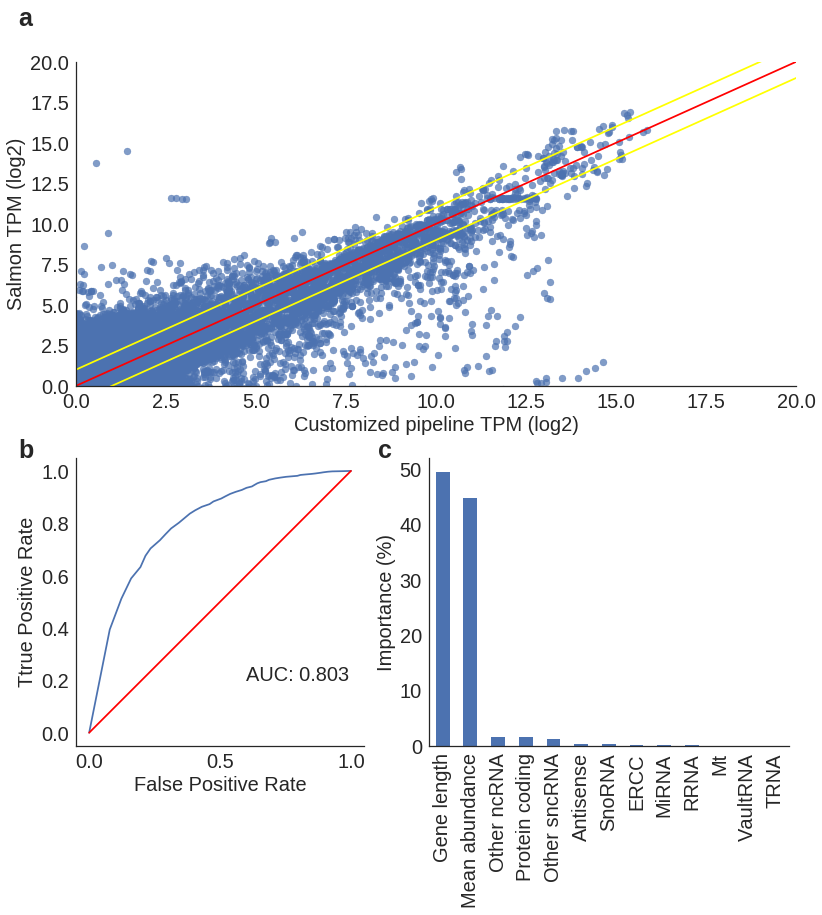

In [181]:
figurepath = '/stor/work/Lambowitz/cdw2854/bench_marking/figures'
figurename = figurepath + '/roc_discordant.png'

FONT_SIZE = 20

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)

sns.set_style('white')
fig = plt.figure(figsize=(10,10))
ax_gene = fig.add_axes([0.08,0.5,1,0.45])
ax_roc = fig.add_axes([0.08,0,0.4,0.4])
ax_importance = fig.add_axes([0.57, 0,0.5,0.4])
plot_gene_expression(df, tolerate, ax_gene)
plot_roc(Y_test, pred_y, ax_roc)
plot_importance(rf, columns, ax_importance)
fig.text(0,1,'a', weight='bold', fontsize=25)
fig.text(0,0.4,'b',weight='bold', fontsize=25)
fig.text(0.5,0.4,'c',weight='bold', fontsize=25)
plt.savefig(figurename, transparent=True, bbox_inches='tight')
print 'Saved: ', figurename